In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm_notebook

In [57]:
df_prec = pd.read_csv('precedents.csv', sep = ';')

In [2]:
df_prec = pd.read_csv('prec_with_corrections.csv', sep = ',')
df_prec.columns

Index(['ten_code', 'six_code', 'prec_description', 'corrections'], dtype='object')

In [3]:
df_prec = df_prec[df_prec['corrections'].map(len) > 1].reset_index(drop=True)
#df_prec = df_prec.drop_duplicates().reset_index(drop=True)                 #if we delete duplicates
len(df_prec)

978244

mean description length:  4.906167581912079+-3.4718857482746337


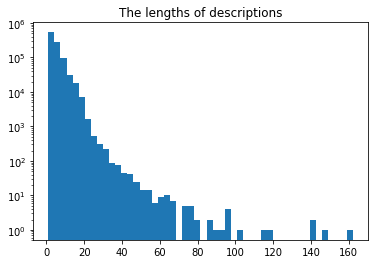

In [4]:
descrp_lens = [len(df_prec['corrections'][i].split()) for i in range(len(df_prec))]
df_prec['descrp_lens'] = descrp_lens
print('mean description length: ', str(np.mean(np.array(descrp_lens)))+ '+-' + str(np.std(np.array(descrp_lens)))) 
plt.hist(descrp_lens, bins=50)
plt.title('The lengths of descriptions')
plt.yscale('log')

In [5]:
df_prec = df_prec[df_prec.descrp_lens < 100].reset_index(drop=True)

Text(0.5, 1.0, 'The lengths of descriptions')

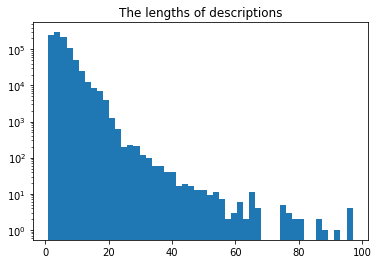

In [6]:
plt.hist(df_prec['descrp_lens'], bins=50)
plt.yscale('log')
plt.title("The lengths of descriptions")

In [7]:
del descrp_lens

In [8]:
class_counts = Counter(df_prec['six_code'])
classes = []
classes += [k for k, v in class_counts.items() if v >= 800]
len(classes)

206

In [10]:
del df_prec

In [9]:
df_short = pd.DataFrame()
df_short = df_prec.loc[df_prec['six_code'].isin(classes)]
df_short.head()

,ten_code,six_code,prec_description,corrections,descrp_lens
0,7308909809,730890,части магистрального ленточного конвейера круп...,части магистрального ленточного конвейера круп...,16
1,8431498009,843149,компоненты гусеничного крана бывший в употребл...,компоненты гусеничного крана бывший употреблен...,15
2,3919900000,391990,скотч,скотч,1
3,7326909409,732690,балка,балка,1
4,7326909409,732690,уголки,уголки,1


In [11]:
d = {ni: indi for indi, ni in enumerate(set(df_short['six_code']))}
numbers = [d[ni] for ni in df_short['six_code']]

df_short['classes_six'] = numbers

In [113]:
df_short = pd.read_csv('prec_with_lemmas.csv', sep = ',')

In [54]:
codes_dict = Counter(df_prec['ten_code'])

sum_1000, sum_100, sum_10, sum_0 = 0, 0, 0, 0
for value in dict(codes_dict).values():
#    print(key, value)
    if value > 1000:
        sum_1000 +=1
    elif 100 < value < 1000:
        sum_100 += 1
    elif 10 < value < 100:
        sum_10 +=1
    else:
        sum_0 +=1
        

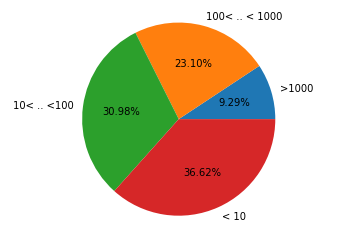

In [55]:
labels = ['>1000', '100< .. < 1000', '10< .. <100', '< 10']
values = [sum_1000, sum_100, sum_10, sum_0]
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels, autopct='%1.2f%%')
ax1.axis('equal')
#ax1.legend(loc='best');
plt.show()

In [46]:
from pymystem3 import Mystem               #lemmatization

m = Mystem()
lemmas = [''.join(m.lemmatize(description)).strip() for description in tqdm_notebook(df_short['corrections'])]
df_short['lemmas'] = lemmas

In [16]:
df_short = df_short[df_short['lemmas'].map(len) > 1].reset_index(drop=True)

In [22]:
df_short.to_csv('prec_with_lemmas.csv') 

In [56]:
df_short.head()

,ten_code,six_code,prec_description,corrections,descrp_lens,classes_six
0,7308909809,730890,части магистрального ленточного конвейера круп...,части магистрального ленточного конвейера круп...,16,89
1,8431498009,843149,компоненты гусеничного крана бывший в употребл...,компоненты гусеничного крана бывший употреблен...,15,159
2,3919900000,391990,скотч,скотч,1,118
3,7326909409,732690,балка,балка,1,6
4,7326909409,732690,уголки,уголки,1,6


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 

In [13]:
from sklearn.model_selection import train_test_split

seed=42
#data_train, data_test = train_test_split(df_short, test_size=0.1, shuffle = True, random_state=seed)
data_train, data_val = train_test_split(df_short, test_size=0.2, shuffle = True, random_state=seed, stratify=list(df_short['six_code']))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  679827
Validation size =  169957


In [25]:
data_train = data_train.drop_duplicates()
data_val = data_val.drop_duplicates()

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  228145
Validation size =  86152


In [14]:
def data_without_stopws(data, stopws):
    corrections_stopws = []
    for text in list(data['corrections']):
        text_clean = ' '.join([word for word in text.split() if word not in stopws])
        corrections_stopws.append(text_clean)
    return corrections_stopws

In [15]:
vectorizer = CountVectorizer(min_df=2)
vectorizer.fit(data_train['corrections'])
stopws = vectorizer.stop_words_
print(len(stopws))

corr_stopws_train = data_without_stopws(data_train, stopws)
corr_stopws_val = data_without_stopws(data_val, stopws)
data_train['corrections'] = corr_stopws_train
data_val['corrections'] = corr_stopws_val

data_train = data_train[data_train['corrections'].map(len) > 1].reset_index(drop=True)
data_val = data_val[data_val['corrections'].map(len) > 1].reset_index(drop=True)


26903


/home/kirill/CSprogs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/kirill/CSprogs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [16]:
del corr_stopws_train
del corr_stopws_val

In [18]:
del df_short

In [17]:
print("Train size after stopwords deletion= ", len(data_train))
print("Validation size after stopwords deletion = ", len(data_val))


Train size after stopwords deletion=  679515
Validation size after stopwords deletion =  169832


In [90]:
data_train.head()

,ten_code,six_code,prec_description,corrections,descrp_lens,classes_six
0,6505009000,650500,головной убор муж полиэстер акрил,головной убор муж полиэстер акрил,5,86
1,3926909709,392690,трубный фиксатор из пластмассы d,трубный фиксатор пластмассы,3,200
2,4016930005,401693,уплотнительное кольцо o ring b,уплотнительное кольцо ring,3,100
3,8205591000,820559,терка строительная,терка строительная,2,128
4,2710198200,271019,моторное масло titan supersyn w l для легковог...,моторное масло titan supersyn для легкового тр...,9,53


In [19]:
#Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

mb_clf = MultinomialNB(alpha=0.0001)
rf = RandomForestClassifier(n_estimators = 10, n_jobs=-1)
xgb = XGBClassifier()
lr = LogisticRegression(C=0.1, class_weight=None, solver='saga', 
                         multi_class='multinomial', random_state=40)




In [20]:
from nltk.corpus import stopwords
stopws = set(stopwords.words('russian'))

In [21]:
vectorizer = TfidfVectorizer(stop_words = stopws)
X_traintfidf = vectorizer.fit_transform(data_train['corrections'])
#len(vectorizer.stop_words_)

In [22]:
rf.fit(X_traintfidf, data_train['classes_six'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
parameters = {'class_weight':('balanced', None), 'C':[0.1, 1, 10, 20, 50]}
clf = GridSearchCV(lr, parameters, cv=3, scoring='f1_micro')
#pipe = Pipeline([('vect', vectorizer), ('clf', lr)])
clf.fit(train_res, data_train['classes_six'].values)

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: Convergence

In [23]:
parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}
clf = GridSearchCV(mb_clf, parameters, cv=3, scoring='f1_micro')
#pipe = Pipeline([('vect', vectorizer), ('clf', lr)])
clf.fit(train_res, data_train['classes_six'])

GridSearchCV(cv=3, error_score='raise',
       estimator=MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [20]:
mb_clf.fit(train_res, data_train['classes_six'])

MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)

In [24]:
clf.best_params_

{'alpha': 0.0001}

In [56]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', vectorizer), ('clf', rf)])
text_clf.fit(data_train['corrections'], data_train['classes_six'])

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [23]:
X_valtfidf = vectorizer.transform(data_val['corrections'])

In [ ]:
from sklearn.metrics import f1_score
y_pred = rf.predict(X_traintfidf)
f1_score(data_train['classes_six'], y_pred, average='micro')

In [32]:
train_res.data

array([0.03977721, 0.03434718, 0.02401268, ..., 0.00122229, 0.0149539 ,
       0.0355236 ])

In [ ]:
lr.fit(train_res, data_train['classes_six'].values)

In [35]:
from sklearn.metrics import f1_score
y_pred = lr.predict(train_res)
f1_score(data_train['classes_six'], y_pred, average='micro')

0.0991963932525211

In [31]:
X_train['corrections'][10:20]

623841                                  шайба упорная сталь
787751        взрывобезопасное кабельное вводное устройство
24952     заглушка для закрытия отврстия бароскопа газов...
971049    боксы для криопробирок для пробирок поликарбон...
340320    артикул уплотнение материал резина входит сост...
422485                                              ноутбук
837658                                                хомут
478320    угги сапогиженскиеверх текстиль подошва резины...
831754                                        седло клапана
136881                                   сумка воловья кожа
Name: corrections, dtype: object

In [117]:
import htz_vectorizer
from htz_vectorizer import HTZVectorizer

htz = HTZVectorizer()
train_res = htz.fit_transform(data_train['lemmas'], data_train['classes_six'].values)

HBox(children=(IntProgress(value=0, max=184543), HTML(value='')))

HBox(children=(IntProgress(value=0, max=194), HTML(value='')))


(184543, 28217)
(184543, 184543)


In [5]:
print(train_res.shape)

(184543, 194)


In [13]:
test_res = htz.transform(data_val['lemmas'])
test_res

<79090x194 sparse matrix of type '<class 'numpy.float64'>'
	with 1059749 stored elements in Compressed Sparse Row format>

In [14]:
test_res.data

array([0.27648033, 0.05319383, 0.00684907, ..., 0.00391213, 0.00042352,
       0.0049279 ])

In [22]:
rf.fit(train_res, data_train['classes_six'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
from sklearn.metrics import f1_score
y_pred = rf.predict(test_res)
f1_score(data_val['classes_six'], y_pred, average='micro')

0.7283365258785821

In [ ]:
from sklearn.metrics import f1_score
y_pred = rf.predict(X_traintfidf)
f1_score(data_train['classes_six'], y_pred, average='micro')

In [108]:
feature_names = vectorizer.get_feature_names()
indices = np.argsort(rf.feature_importances_)
feature_names = [feature_names[i] for i in indices[::-1]]

In [111]:
feature_importances = pd.DataFrame(sorted(rf.feature_importances_, reverse=True), feature_names,
                                    columns=['importance'])
feature_importances[:10]

,importance
хлопок,0.011978
болт,0.011633
футболка,0.011255
шайба,0.009101
уплотнение,0.007698
крем,0.007447
жен,0.006966
полиэстер,0.006316
фланец,0.006296
фильтр,0.006240
